# Opera Software - BI Intern Competence Test

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq

## Load data into database

The provided dataset has been loaded into a database on Google BigQuery

In [2]:
df = gbq.read_gbq("SELECT * FROM test_data.PRODUCT", project_id="opera-220120")

We have now connected to the database on Google BigQuery. Let's take a quick glance at the data we are going to work with

## Data

In [3]:
df.head()

,partition_date,timeperiod,country,full_version,news_locale,channel,source,impressions,clicks,active_users,new_users,retained_01,retained_07,retained_30
0,2018-06-02,2018-06-01,HF,3.3.2254.127986,hw:en,Cross-Promo,Unprecedented_2,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,2018-06-02,2018-06-01,BF,2.4.2254.127188,ba:fr,Cross-Promo,Widespread_4,NaN,NaN,NaN,NaN,3.0,NaN,NaN
2,2018-06-02,2018-06-01,BF,3.3.2254.127986,ba:fr,Cross-Promo,Widespread_4,NaN,NaN,NaN,NaN,10.0,NaN,NaN
3,2018-06-02,2018-06-01,JE,3.3.2254.127986,lv:fr,Cross-Promo,Widespread_4,NaN,NaN,NaN,NaN,11.0,NaN,NaN
4,2018-06-02,2018-06-01,JE,2.4.2254.127188,lv:fr,Cross-Promo,Widespread_4,NaN,NaN,NaN,NaN,4.0,NaN,NaN


The first thing we see is that there are several null values. Let us check how prevelent this is  

In [4]:
df.count()/len(df)*100

partition_date    100.000000
timeperiod        100.000000
country           100.000000
full_version      100.000000
news_locale       100.000000
channel           100.000000
source            100.000000
impressions        39.927218
clicks             37.647839
active_users       50.300488
new_users          50.300488
retained_01         5.805593
retained_07         4.523071
retained_30         3.476683
dtype: float64

The table above shows the percentage of non-null data we have for each column

Let us find out the time range the data covers

In [5]:
max(df["partition_date"])

Timestamp('2018-08-30 00:00:00')

In [6]:
min(df["partition_date"])

Timestamp('2018-06-01 00:00:00')

The data covers three months. From first of June to 30th of August 2018.

## Average daily new user run-rate

In [7]:
new_user_run_rate = df.groupby(["country", "timeperiod"]).sum().groupby("country")["new_users"].mean()
new_user_run_rate

country
BF    1225.262295
DC    2870.360656
GT    2201.688525
HF    2455.672131
IB    1568.590164
JE    1613.098361
JY     661.688525
KI    1804.049180
LP     169.622951
LQ     830.213115
LY     144.213115
OU     355.491803
RE    2448.491803
RO     399.754098
TT     763.262295
TZ     302.819672
UF    2678.606557
WA     226.065574
XJ    1225.213115
ZY    2368.557377
Name: new_users, dtype: float64

This is the average daily new users for the three month period

## Top 10 sources by new users in June

In [8]:
june = df[pd.to_datetime(df["timeperiod"]).dt.month == 6]
top_ten_sources_june = june.groupby(["source"]).sum().nlargest(10, "new_users")

In [9]:
july = df[pd.to_datetime(df["timeperiod"]).dt.month == 7]

In [10]:
df_top_ten_july = july.loc[july["source"].isin(list(top_ten_sources_june.index.values))]

In [11]:
df_top_ten_july.groupby(["source", "timeperiod"]).sum().groupby("source")["active_users"].mean().sort_values(ascending=False)

source
Cryptic_4       84564.870968
Indeed_1        48873.000000
Professor_7     47671.741935
Latent_4        44108.903226
Febrile_8       32720.161290
Widespread_4    10841.838710
Dreams_4        10091.935484
Learned_3        8253.225806
Family_1         7716.000000
Returned_5       7142.129032
Name: active_users, dtype: float64

This is the average active user in July for the top ten sources by user count in June

## Top 5 countries by average retention ratio in June

In [12]:
june_mean = june.groupby(["country", "timeperiod"]).sum().groupby("country")["new_users", "retained_30"].mean()

In [13]:
june_mean["r30_ratio"] = june_mean["retained_30"] / june_mean["new_users"]

In [14]:
top_five_ratio_june = june_mean.nlargest(5, "r30_ratio")
top_five_ratio_june

,new_users,retained_30,r30_ratio
country,,,
OU,330.333333,71.766667,0.217255
KI,1789.133333,350.433333,0.195868
JY,621.366667,112.700000,0.181374
HF,2470.000000,441.133333,0.178596
DC,2700.000000,445.966667,0.165173


These are the top five countries for the daily R30 retention ratio

## User aquisition trends

In the following we assume that the ratio of users retained after 30 days reflect the true growth of good quality users. We will also assume that the ratio between clicks and impressions (Click-Through-Rate or CTR) is a good measure for the effectiveness of a source

In [15]:
sources = df.groupby(["source", "timeperiod"]).sum().groupby("source").sum()
sources["growth"] = sources["retained_30"] / sources["new_users"]
sources["CTR"] = sources["clicks"] / sources["impressions"]

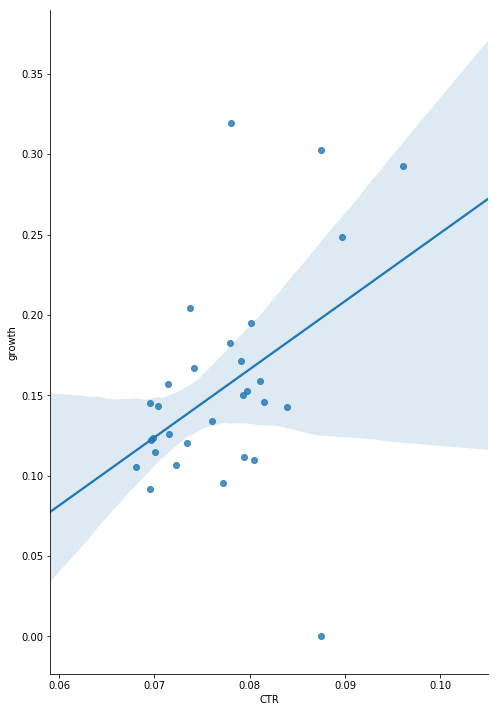

In [16]:
sns.pairplot(sources, x_vars=["CTR"], y_vars="growth", size=10, aspect=0.7, kind="reg")

From the scatterplot we can se that there is seems to be a strong relationship between CTR and growth as we have defined them

In [17]:
feature_cols = ["CTR", "clicks", "impressions"]
X = sources[feature_cols]
y = sources.growth

linreg = LinearRegression()
linreg.fit(X, y)

for i in zip(feature_cols, linreg.coef_):
    print(i)

('CTR', 5.018666746088409)
('clicks', -2.7433881657443655e-08)
('impressions', 2.0739441029407954e-09)


We see that one unit increase in CTR will on average yield 5 unit increases in growth

In [18]:
lm = smf.ols(formula='growth ~ CTR', data=sources).fit()
print(lm.pvalues)

Intercept    0.185124
CTR          0.015290
dtype: float64


This means that we can reject the null hypothesis and declare that there is a relationship between CTR and growth

Let us now create a combination of CTR and growth as a score feature and determine the top 5 sources based upon that feature

In [19]:
sources["score"] = sources["CTR"] * sources["growth"]
sources.nlargest(5, "score")

,impressions,clicks,active_users,new_users,retained_01,retained_07,retained_30,growth,CTR,score
source,,,,,,,,,,
Unprecedented_2,1647563.0,158255.0,16079.0,612.0,376.0,253.0,179.0,0.292484,0.096054,0.028094
Astonished_8,17061670.0,1493145.0,187238.0,7508.0,4488.0,3058.0,2271.0,0.302477,0.087515,0.026471
Interview_5,1226255.0,95722.0,8174.0,385.0,284.0,188.0,123.0,0.319481,0.078060,0.024939
Professor_3,3826121.0,343174.0,40316.0,1160.0,618.0,450.0,288.0,0.248276,0.089692,0.022268
Mentioned_4,1215555.0,97399.0,13759.0,800.0,421.0,211.0,156.0,0.195000,0.080127,0.015625


### Conclusion
Based upon our previous stated assumptions and the assumption that we can use a linear model to determine a relationship between our features, we have found that the table will show the sources that will bring good users in volume